In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import mnist_reader
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
plt.rcParams["figure.figsize"] = (15,5)

# Ejercicio descriptores

El objetivo de este ejercicio es trabajar con la descripción de objetos y texturas usando HOG (Histogram of Oriented Gradients) y GLCM (Grey-Level Co-Matrix). Se caracterizarán un conjunto de imágenes del dataset de Zalando (https://github.com/zalandoresearch/fashion-mnist) utilizando GLCM normalizado como histograma, un vector con diferentes medidas sobre el GLCM y HOG. Mediante estas características entrenaremos un clasificador KNN y comprobaremos cómo de bien puede clasificar según el descriptor utilizado.

## GLDV

In [2]:
#GLDV (Grey-level difference vector)
def calc_gldv(glcm):
    gldv = np.zeros(len(glcm))
    for i in range(len(glcm)):
        if(i>0):
            gldv[i]=np.trace(glcm, offset=i)*2
        else:
            gldv[i]=np.trace(glcm, offset=i)
            
    return gldv

## Carga de datos de Zalando

Cargamos los datos utilizando la función que podemos encontrar directamente en el github ya mencionado.  
NOTA: este conjunto de datos y la función para cargarlos están pensadas para entrenar redes neuronales por lo tanto lo que nos devuelve es un array de dimensiones (N,784), donde N es el número de elementos (60000 para el conjunto de train y 10000 para el conjunto de test) y 784 son los píxles de una imagen de 28x28 aplanados.

In [187]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

Juntamos ambos datasets, ya que vamos a crear nuestro propio dataset más pequeño

In [188]:
X_dataset = np.concatenate((X_train,X_test))
Y_dataset = np.concatenate((y_train,y_test))

Las etiquetas del conjunto de Zalando son las siguientes:

In [100]:
y_labels_names = ['T-shirt/top',
                  'Trouser',
                  'Pullover',
                  'Dress',
                  'Coat',
                  'Sandal',
                  'Shirt',
                  'Sneaker',
                  'Bag',
                  'Ankle boot']

## Crear nuestro propio dataset

De todo el conjunto total nos piden sacar 100 elementos de 4 o 6 clases para obtener los descriptores y clasificar. A continuación se muestra una función con la cual podremos sacar N elementos de M clases.

In [196]:
def my_sample(X, Y, labels, elements):
    # labels: array con las clases que queremos coger entre 0 y 9 incluidos.
    
    # elements: especificamos cuántos elementos de cada clase queremos coger, máximo de 7000 ya que el conjunto de
    # Zalando tiene 6000+1000 en train+test para cada clase
    
    #Creamos nuestro propio dataset reducido
    my_X_dataset = np.zeros((elements*len(labels),28*28))
    my_Y_dataset = np.zeros(elements*len(labels))
    for i in range(len(labels)):
        ind = (Y==labels[i])
        my_X_dataset[i*elements:elements*(i+1),] = X[ind][0:elements]
        my_Y_dataset[i*elements:elements*(i+1)] = Y[ind][0:elements]

    # Convertimos las imágenes a uint8 y pasamos las imágenes de un array de 784 a una matriz 28x28
    my_X_dataset = my_X_dataset.astype(np.uint8).reshape(elements*len(labels),28,28)
    
    # Las etiquetas también las pasamos a uint8 de flot64
    my_Y_dataset = my_Y_dataset.astype(np.uint8)
    return my_X_dataset, my_Y_dataset

A continuación visualizamos un ejemplo de cada conjunto para escoger qué tipo de ropa vamos a clasificar. Intetaremos escoger algún tipo que no se parezcan mucho y obtener una buena clasificación. Aunque podamos pensar que para una persona dos imágenes no se parecen, dependiendo del descriptor es posible que sí se parezcan y viceversa, por lo tanto esta decisión inicial es tan solo una suposición.

In [197]:
example_image, example_label = my_sample(X_dataset, Y_dataset, elements=1, labels=[0,1,2,3,4,5,6,7,8,9])

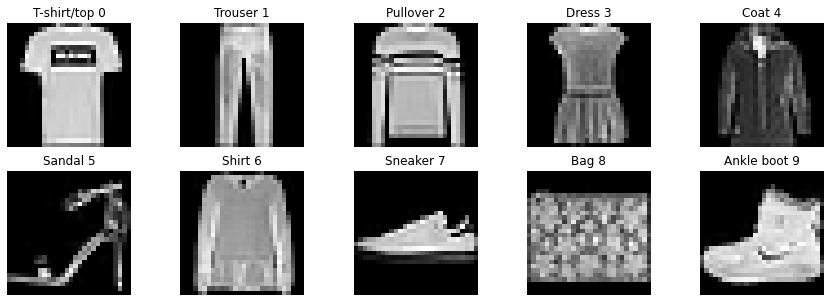

In [198]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(example_image[i], cmap='gray')
    plt.title(y_labels_names[example_label[i]]+' '+str(i))

A pesar de haber visto tan solo un ejemplo de cada conjunto, consideramos que las camisetas/tops (0), los pantalones (1), las sandalías (5) y los bolsos (8) son conjutos bastante diferentes, por lo tanto calcularemos los descriptores para estos conjuntos.

In [199]:
my_X_dataset, my_Y_dataset = my_sample(X_dataset, Y_dataset, elements=100, labels = [0,1,5,8])

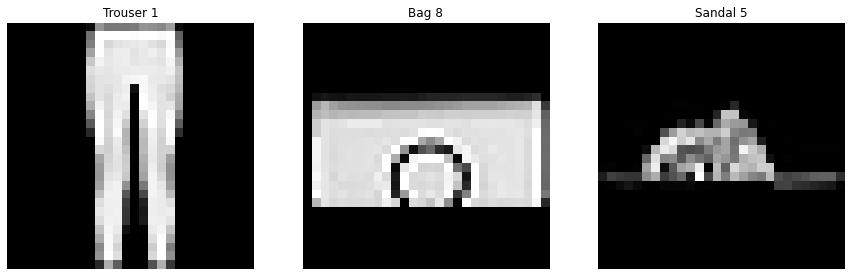

In [204]:
# Visualizamos 3 ejemplos aleatorios de nuestro conjunto de datos
np.random.seed(42)
index = np.random.choice(len(my_X_dataset),3)
for i in range(len(index)):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_dataset[index[i]], cmap='gray');
    plt.title(y_labels_names[my_Y_dataset[index[i]]] + ' ' + str(my_Y_dataset[index[i]]))

In [205]:
# Dividimos nuestro dataset en train y test mediante el uso de train_test_split de scikit-learn
my_X_train, my_X_test, my_y_train, my_y_test = train_test_split(my_X_dataset, my_Y_dataset, test_size=0.2, random_state=5, shuffle =True)

In [206]:
# Revisamos la distribución que ha hecho scikit de los datos de train
u, counts = np.unique(my_y_train, return_counts=True)
print(u)
print(counts)

[0 1 5 8]
[82 81 83 74]


In [207]:
# Revisamos la distribución que ha hecho scikit de los datos de tes
u, counts = np.unique(my_y_test, return_counts=True)
print(u)
print(counts)

[0 1 5 8]
[18 19 17 26]


###  Comprobar que las etiquetas se corresponden con las imágenes de nuestro conjunto de train y test

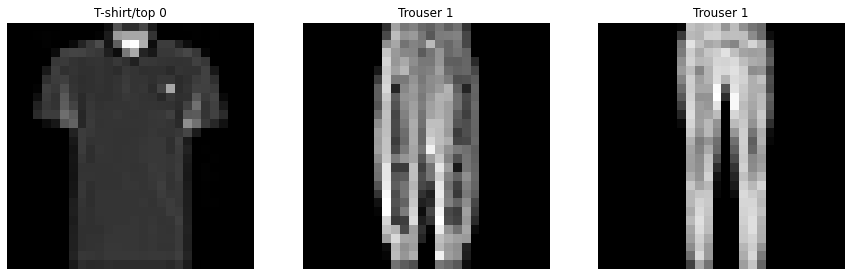

In [209]:
index = np.random.choice(len(my_X_train),3)
np.random.seed(42)
for i in range(len(index)):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_train[index[i]], cmap='gray');
    plt.title(y_labels_names[my_y_train[index[i]]] + ' ' + str(my_y_train[index[i]]))

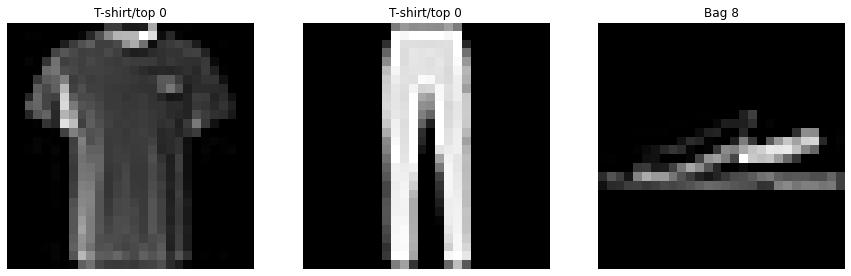

In [210]:
index = np.random.choice(len(my_X_test),3)
np.random.seed(42)
for i in range(len(index)):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_test[index[i]], cmap='gray')
    plt.title(y_labels_names[my_y_train[index[i]]] + ' ' + str(my_y_train[index[i]]))

### Métricas GLCM

Skimage proporciona directamente el cáclulo de diferentes propiedades de la GLCM mediante la función *greycoprops(GLCM, prop='measure')* donde measure puede ser una de las siguientes métricas:  

- ‘contrast’: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$  
- ‘dissimilarity’: $\sum_{i,j=0}^{levels-1} P_{i,j}|i-j|$  
- ‘homogeneity’ : $\sum_{i,j=0}^{levels-1} \frac{P_{i,j}}{1+(i-j)^2}$  
- ‘ASM’ $\sum_{i,j=0}^{levels-1} P^2_{i,j}$   
- ‘energy’ $\sqrt{ASM}$  
- ‘correlation’  $\sum_{i,j=0}^{levels-1} P_{i,j}\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{\sigma_i^2\sigma_j^2}}$

In [214]:
def glcm_props (glcm):
    contrast      = greycoprops(glcm,'contrast')
    dissimilarity = greycoprops(glcm,'dissimilarity')
    homogeneity   = greycoprops(glcm,'homogeneity')
    ASM           = greycoprops(glcm,'ASM')
    #energy       = greycoprops(glcm,'energy')
    correlation   = greycoprops(glcm,'correlation')
    return np.array([dissimilarity, correlation, contrast, homogeneity, ASM])

A continuación se describe la función para calcular tanto la GLCM como las métricas que hemos descrito antes. Esto se obtendrá para cada imagen.

### GLCM

In [215]:
# Función para calcular las GLCM y sus métricas. Devuelve las GLCM y sus métricas.
def calc_glcm (dataset):
    measures = np.zeros([len(dataset),5])
    # Calulamos todas las medidas para cada imagen.
    glcm_hists = np.zeros([len(dataset),256*256])
    for i in range(len(measures)):
        glcm = greycomatrix(dataset[i],distances=[1],angles=[0],levels=256,symmetric=True,normed=True)
        measures[i,:] = glcm_props(glcm).flatten()
        glcm_hists[i,:] = glcm.flatten()
    return glcm_hists, measures


## Descriptor 1 y 2: GLCM como histograma y vector de métricas de GLCM

In [277]:
glcm_hist_train , measures_train = calc_glcm(my_X_train)
glcm_hist_test , measures_test = calc_glcm(my_X_test)

### Clasificador KNN con descriptores GLCM como histograma

In [232]:
#Esta es nuetra función de distancia entre 2 histogramas
def hist_chisquare (H1, H2):
    index = (H1 != 0)
    return np.sum((H1[index]-H2[index])**2/(H1[index]))


Precición entrenamiento GLCM histograma:  84.06 %


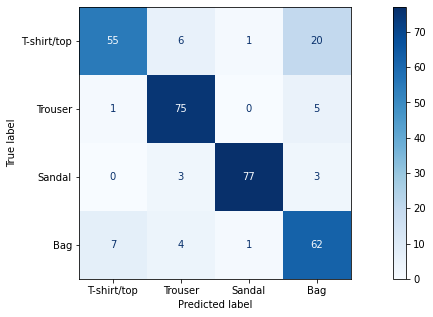

In [244]:
neigh_glcm = KNeighborsClassifier(n_neighbors=5, metric=hist_chisquare)
neigh_glcm.fit(glcm_hist_train, my_y_train)

y_pred_glcm = neigh_glcm.predict(glcm_hist_train)

print('Precición entrenamiento GLCM histograma: ',np.round(accuracy_score(my_y_train, y_pred_glcm)*100,2),'%')
plot_confusion_matrix(neigh_glcm,
                      glcm_hist_train,
                      my_y_train,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_test)],
                      cmap=plt.cm.Blues);


Precición test GLCM histograma:  78.75 %


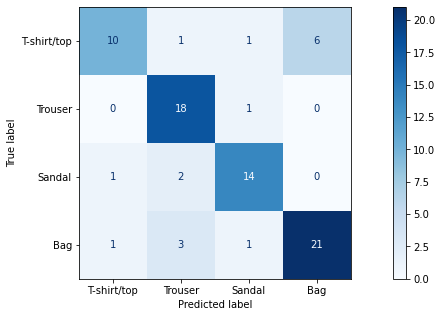

In [245]:
y_pred_glcm = neigh_glcm.predict(glcm_hist_test)
print('Precición test GLCM histograma: ',np.round(accuracy_score(my_y_test, y_pred_glcm)*100,2),'%')
plot_confusion_matrix(neigh_glcm,
                      glcm_hist_test,
                      my_y_test,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_test)],
                      cmap=plt.cm.Blues);

Este primer clasificador con GLCM como histograma consigue una precisión de l casi 80% para el conjunto de datos que hemos escogido (camisetas, pantalos, sandalías y bolsos). Podemos observar que tanto para el entrenamiento y el test en el caso que más se equivoca es en las camisetas, en nuestro caso ha clasificado 6 camisetas como bolso. A continuación veremos un ejemplo de esta clasificación incorrecta.

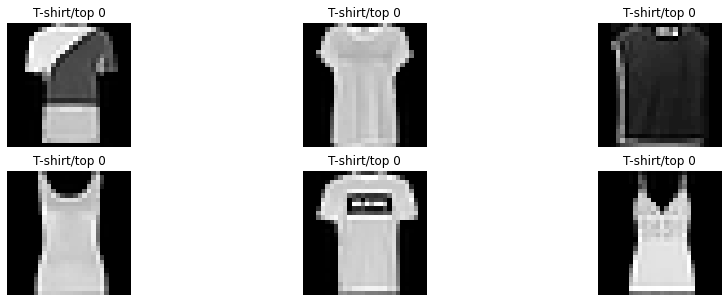

In [381]:
index_camisetas = my_y_test == 0 # índices que son camisetas en el conjunto de test
index_pred_bolso = y_pred_glcm == 8 # índices que se han predicho como bolsos

#AND "bit a bit" para obtener los índices de las camisetas que se han predicho como bolso
ind_camisetas_como_bolso = np.bitwise_and(index_camisetas, index_pred_bolso) 

# Mostramos por pantalla las 6 clasificaciones de camisetas como bolsos
index = np.array(np.where(ind_camisetas_como_bolso)).ravel()
np.random.seed(42)
for i in range(len(index)):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_test[index[i]], cmap='gray');
    plt.title(y_labels_names[my_y_test[index[i]]] + ' ' + str(my_y_test[index[i]]))

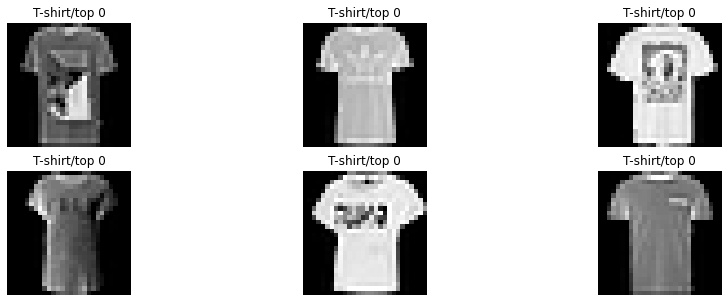

In [396]:
index_pred_camiseta = y_pred_glcm == 0 # índices que se han predicho como camisetas

#AND "bit a bit" para obtener los índices de las camisetas que se han predicho como camisetas
ind_camisetas_como_camiseta = np.bitwise_and(index_camisetas, index_pred_camiseta)

# Mostramos por pantalla 6 clasificaciones de camisetas como camisetas
index = np.array(np.where(ind_camisetas_como_camiseta)).ravel()
index = index[0:6]
np.random.seed(42)
for i in range(len(index)):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_test[index[i]], cmap='gray');
    plt.title(y_labels_names[my_y_test[index[i]]] + ' ' + str(my_y_test[index[i]]))

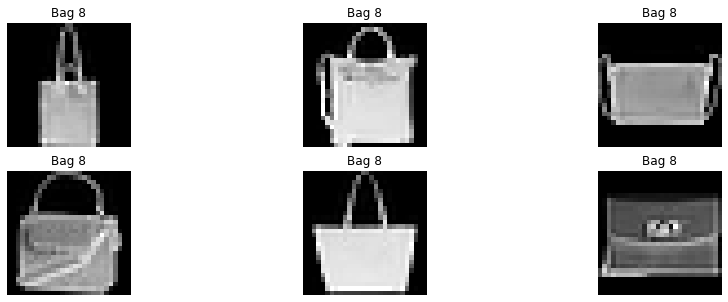

In [397]:
index_bolso = my_y_test == 8 # índices que son bolsos en el conjunto de test

#AND "bit a bit" para obtener los índices de los bolsos que se han predicho como bolsos
ind_bolso_como_bolso = np.bitwise_and(index_bolso, index_pred_bolso)

# Mostramos por pantalla 6 clasificaciones de bolsos como bolsos
index = np.array(np.where(ind_bolso_como_bolso)).ravel()
index = index[0:6]
np.random.seed(42)
for i in range(len(index)):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(my_X_test[index[i]], cmap='gray');
    plt.title(y_labels_names[my_y_test[index[i]]] + ' ' + str(my_y_test[index[i]]))

Observando visualmente los ejemplos que se han predicho incorrectamente de las camisetas parece ser que el GLCM como histograma en caso de camisetas que no tiene estampado o que son muy planas en cuanto a texturas se confunde con los bolsos. Si observamos los bolsos bien clasificados podemos ver que, en los 6 ejemplos, los bolsos suelen tener poca textura. En cambio si miramos las camisetas bien clasificadas estas suelen tener algún tipo de estampado que genera texturas diferentes.

In [259]:
glcm_hist_test[0,:]

array([0.53439153, 0.01917989, 0.00462963, ..., 0.        , 0.        ,
       0.        ])

5


(array([569.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00066138, 0.05403439, 0.10740741, 0.16078042, 0.21415344,
        0.26752646, 0.32089947, 0.37427249, 0.4276455 , 0.48101852,
        0.53439153]),
 <BarContainer object of 10 artists>)

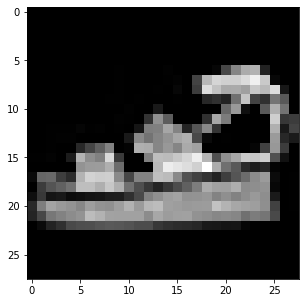

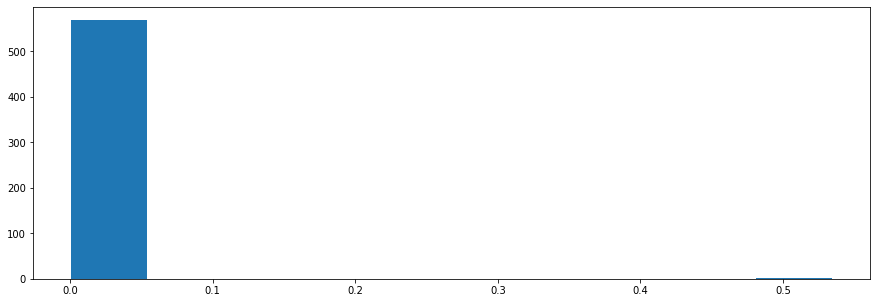

In [383]:
index = 0
print(my_y_test[index])
plt.figure()
plt.imshow(my_X_test[index], cmap='gray')
plt.figure()
plt.hist(glcm_hist_test[index,glcm_hist_test[index,:]!=0])

In [299]:
np.sum(glcm_hist_test[index,:]!=0)

570

(array([64966.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([0.0e+00, 5.0e-09, 1.0e-08, 1.5e-08, 2.0e-08, 2.5e-08, 3.0e-08,
        3.5e-08, 4.0e-08, 4.5e-08, 5.0e-08]),
 <BarContainer object of 10 artists>)

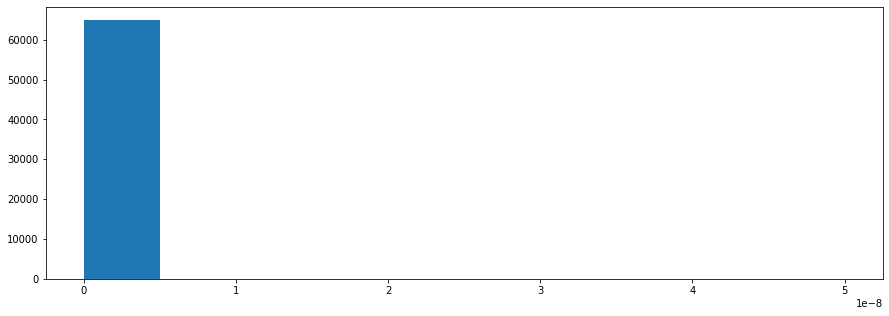

In [297]:
plt.figure()
plt.hist(glcm_hist_test[index,:], range =(0,0.00000005) )

### Clasificador KNN con descriptores como vector de propiedades de GLCM

Precición entrenamiento GLCM métricas:  60.0 %


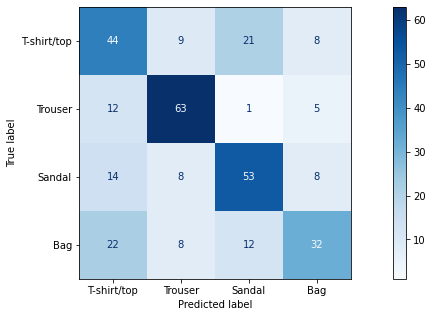

In [417]:
neigh_measures = KNeighborsClassifier(n_neighbors=5, metric = 'euclidean')
neigh_measures.fit(measures_train, my_y_train)

y_pred_measures = neigh_measures.predict(measures_train)

print('Precición entrenamiento GLCM métricas: ',np.round(accuracy_score(my_y_train, y_pred_measures)*100,2),'%')
plot_confusion_matrix(neigh_measures,
                      measures_train,
                      my_y_train,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_train)],
                      cmap=plt.cm.Blues);

Precición test GLCM métricas:  46.25 %


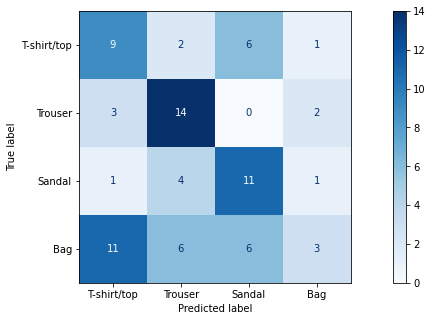

In [418]:
y_pred_measures = neigh_measures.predict(measures_test)

print('Precición test GLCM métricas: ',np.round(accuracy_score(my_y_test, y_pred_measures)*100,2),'%')
plot_confusion_matrix(neigh_measures,
                      measures_test,
                      my_y_test,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_test)],
                      cmap=plt.cm.Blues);

Para el caso del vector de métricas de GLCM se comprueba que la predicción que consigue es bastante deficiente. Las métricas que se obtienen a partir del GLCM no son suficientes para caracterizar nuestro conjunto de imágenes. Habría que obtener nuevas y/o distintas métricas para intentar conseguir caracterizar nuestro conjunto de imágenes y mejorar la predicción. Al fin y al cabo, cada una de las métricas resume en un valor todo el histograma de 65536 valores (a pesar de que la mayoría sean ceros por la cantidad de niveles de gris que consideramos se ha comprobado que junto con aquellos valores que no son ceros se consigue caracterizar las imágenes de test).

## Descriptor 3: HOG

In [398]:
# Parámetros para ajustar el descriptor HOG
winSize = (28,28) # Tamaño de nuestra imagen directamente porque queremos un descriptor para toda la imagen
blockSize = (14,14) # 
blockStride = (7,7) #   
cellSize = (14,14) #
nbins = 9
derivAperture = 1 # No cambiar
winSigma = -1. # No cambiar
histogramNormType = 0 # No cambiar
L2HysThreshold = 0.2 # No cambiar
gammaCorrection = 1 # No cambiar
nlevels = 64 # No cambiar
useSignedGradients = True

# Descriptor HOG con los parámetros anteriores
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, useSignedGradients)

# Suponemos que se pasa un dataset de [N,(28*28)] imágenes en escala de grises
def calc_hog (dataset):
    hog_descriptors = np.zeros([len(dataset),81])
    for i in range(len(dataset)):
        hog_descriptors[i,:] = hog.compute(dataset[i]).flatten()
    return hog_descriptors   

In [409]:
hog_descriptors_train = calc_hog(my_X_train)
hog_descriptors_test =calc_hog(my_X_test)

Precición entrenamiento HOG:  97.5 %


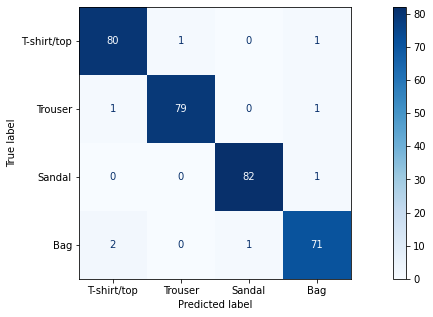

In [413]:
neigh_hog = KNeighborsClassifier(n_neighbors=3)
neigh_hog.fit(hog_descriptors_train, my_y_train)
y_pred_hog = neigh_hog.predict(hog_descriptors_train)
print('Precición entrenamiento HOG: ',np.round(accuracy_score(my_y_train, y_pred_hog)*100,2),'%')
plot_confusion_matrix(neigh_hog,
                      hog_descriptors_train,
                      my_y_train,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_train)],
                     cmap=plt.cm.Blues);

Precisión test HOG:  98.75 %


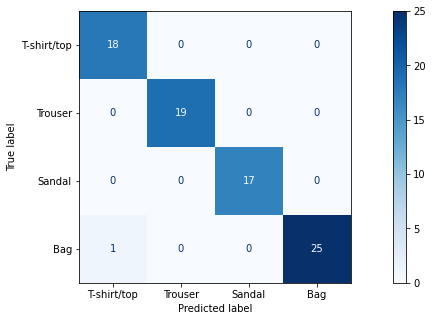

In [414]:
neigh_hog = KNeighborsClassifier(n_neighbors=3)
neigh_hog.fit(hog_descriptors_test, my_y_test)
y_pred_hog = neigh_hog.predict(hog_descriptors_test)
print('Precisión test HOG: ',np.round(accuracy_score(my_y_test, y_pred_hog)*100,2),'%')
plot_confusion_matrix(neigh_hog,
                      hog_descriptors_test,
                      my_y_test,
                      display_labels=[y_labels_names[i] for i in np.unique(my_y_test)],
                     cmap=plt.cm.Blues);

En el caso de HOG obtenemos una clasificación casi perfecta en nuestro conjunto de test. Tenemos una precisión de 98,75% clasificando erróneamente tan solo una imagen. En el conjunto de entrenamiento obtenemos un 97,5% de precisión clasificando correctamente 312 de 320 ejemplos.  
Veamos a continuación qué imagen se ha clasificado incorrectamente.

Referencias externas
https://learnopencv.com/histogram-of-oriented-gradients/
https://prism.ucalgary.ca/bitstream/handle/1880/51900/texture%20tutorial%20v%203_0%20180206.pdf?sequence=11&isAllowed=y
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

In [274]:
# Función para calcular las GLCM y sus métricas pasando las imágenes a 16 niveles de gris en vez de 256
def calc_glcm2 (dataset):
    measures = np.zeros([len(dataset),5])
    # Calulamos todas las medidas para cada imagen.
    glcm_hists = np.zeros([len(dataset),16*16])
    for i in range(len(measures)):
        image = dataset[i].copy()
        image = np.floor(image/16)
        image = image.astype(np.uint8)
        glcm = greycomatrix(image,distances=[1],angles=[0],levels=16,symmetric=True,normed=True)
        glcm_hists[i,:] = glcm.flatten()
        measures[i,:] = glcm_props(glcm).flatten()
    return glcm_hists, measures


In [275]:
glcm_hist_train , measures_train = calc_glcm2(my_X_train)
glcm_hist_test , measures_test = calc_glcm2(my_X_test)